In [1]:
# Dependencies
# ----------------------------------
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, Integer, String, Float
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

Base = declarative_base()

import pandas as pd


In [2]:
# Create Database Connection
# ----------------------------------
# database_path = "pets_db"
# engine = create_engine(f"sqlite:///{database_path}")
#

# Found this suggestion from a Google search.
# The order of the 5 parameters is username, password, location, port, database name

url_string = 'postgresql://{}:{}@{}:{}/{}'
url_string = url_string.format('postgres', 'postgres', 'localhost', 5432, 'SQL_Homework')
engine = create_engine(url_string)
conn = engine.connect()


In [3]:
####  Create a "Metadata" Layer That Abstracts our SQL Database
#### ----------------------------------
Base.metadata.create_all(engine)

In [4]:
#### Use the Inspector to explore the database, print the table names, column names and data types
inspector = inspect(engine)
tables = inspector.get_table_names()
print (f'The table names are {tables}\n')

print ('Start of Table Definitions')
for table in tables:
  cols = inspector.get_columns(table)
  print ('-'*30)
  print (f'{table}')
  for col in cols:
      print(col["name"], col["type"])
print ('-'*30)
print ('End of Table Definitions')

The table names are ['employees', 'dept_emp', 'depts', 'dept_mgr', 'salaries', 'titles']

Start of Table Definitions
------------------------------
employees
emp_no INTEGER
birth_date DATE
first_name VARCHAR(20)
last_name VARCHAR(20)
gender VARCHAR(1)
hire_date DATE
------------------------------
dept_emp
emp_no INTEGER
dept_no VARCHAR(4)
from_date DATE
to_date DATE
------------------------------
depts
dept_no VARCHAR(4)
dept_name VARCHAR(20)
------------------------------
dept_mgr
dept_no VARCHAR(4)
emp_no INTEGER
from_date DATE
to_date DATE
------------------------------
salaries
emp_no INTEGER
salary REAL
from_date DATE
to_date DATE
------------------------------
titles
emp_no INTEGER
title VARCHAR(20)
from_date DATE
to_date DATE
------------------------------
End of Table Definitions


In [5]:
#### Reflect Database into ORM class
Base = automap_base()
Base.prepare(engine, reflect=True)
Employees = Base.classes.employees
Salaries = Base.classes.salaries
Titles = Base.classes.titles

#### Start a session to query the database
session = Session(engine)

In [6]:
#### Now read the required tables into panda dataframes
employees_df = pd.read_sql_query(session.query(Employees).statement, session.bind)
salaries_df = pd.read_sql_query(session.query(Salaries).statement, session.bind)
titles_df = pd.read_sql_query(session.query(Titles).statement, session.bind)

In [7]:
# Take a look at the employees dataframe
print (f'The number of rows is {len(employees_df):,}')
employees_df.head()

The number of rows is 300,024


,emp_no,birth_date,first_name,last_name,gender,hire_date
0,10001,1953-09-02,Georgi,Facello,M,1986-06-26
1,10002,1964-06-02,Bezalel,Simmel,F,1985-11-21
2,10003,1959-12-03,Parto,Bamford,M,1986-08-28
3,10004,1954-05-01,Chirstian,Koblick,M,1986-12-01
4,10005,1955-01-21,Kyoichi,Maliniak,M,1989-09-12


In [8]:
# Take a look at the salaries dataframe
print (f'The number of rows is {len(salaries_df):,}')
salaries_df.head()

The number of rows is 300,024


,emp_no,salary,from_date,to_date
0,10001,60117.0,1986-06-26,1987-06-26
1,10002,65828.0,1996-08-03,1997-08-03
2,10003,40006.0,1995-12-03,1996-12-02
3,10004,40054.0,1986-12-01,1987-12-01
4,10005,78228.0,1989-09-12,1990-09-12


In [9]:
# Take a look at the titles dataframe
print (f'The number of rows is {len(titles_df):,}')
titles_df.head()

The number of rows is 443,308


,emp_no,title,from_date,to_date
0,10001,Senior Engineer,1986-06-26,9999-01-01
1,10002,Staff,1996-08-03,9999-01-01
2,10003,Senior Engineer,1995-12-03,9999-01-01
3,10004,Engineer,1986-12-01,1995-12-01
4,10004,Senior Engineer,1995-12-01,9999-01-01


### Note that the Titles dataframe has more rows than Employees and Salaries.  From looking at the first 5 rows, it appears that the history of promotions has been included.  I will limit the dataframe to the most recent records, and see if we get the same number of rows.

In [10]:
# Find the most recent title for each employee
titles2_df = titles_df.sort_values('to_date').groupby('emp_no').last()
print (f'The number of rows is {len(titles2_df):,}')
titles2_df.head()

The number of rows is 300,024


,title,from_date,to_date
emp_no,,,
10001,Senior Engineer,1986-06-26,9999-01-01
10002,Staff,1996-08-03,9999-01-01
10003,Senior Engineer,1995-12-03,9999-01-01
10004,Senior Engineer,1995-12-01,9999-01-01
10005,Senior Staff,1996-09-12,9999-01-01


### Now we have the same number of rows in all three datasets.  Merge the datasets and drop any NAs

In [11]:
employees_salaries_df = pd.merge (employees_df, salaries_df, on='emp_no')
employees_data_df = pd.merge (employees_salaries_df, titles2_df, on='emp_no')
employees_data_df.dropna(inplace=True)
print (f'The number of rows is {len(employees_data_df):,}')
employees_data_df.head()

The number of rows is 300,024


,emp_no,birth_date,first_name,last_name,gender,hire_date,salary,from_date_x,to_date_x,title,from_date_y,to_date_y
0,10001,1953-09-02,Georgi,Facello,M,1986-06-26,60117.0,1986-06-26,1987-06-26,Senior Engineer,1986-06-26,9999-01-01
1,10002,1964-06-02,Bezalel,Simmel,F,1985-11-21,65828.0,1996-08-03,1997-08-03,Staff,1996-08-03,9999-01-01
2,10003,1959-12-03,Parto,Bamford,M,1986-08-28,40006.0,1995-12-03,1996-12-02,Senior Engineer,1995-12-03,9999-01-01
3,10004,1954-05-01,Chirstian,Koblick,M,1986-12-01,40054.0,1986-12-01,1987-12-01,Senior Engineer,1995-12-01,9999-01-01
4,10005,1955-01-21,Kyoichi,Maliniak,M,1989-09-12,78228.0,1989-09-12,1990-09-12,Senior Staff,1996-09-12,9999-01-01


### Phew!  All the employee, salary and titles data has survived the merge!

In [12]:
# Now, calculate the average salary per title.
avg_salary_df = pd.DataFrame(employees_data_df.groupby('title')['salary'].mean())
print (f'The number of rows is {len(avg_salary_df):,}')
avg_salary_df.head(10)

The number of rows is 7


,salary
title,
Assistant Engineer,48564.434447
Engineer,48535.174946
Manager,49600.555556
Senior Engineer,48506.877189
Senior Staff,58503.651168
Staff,58433.549172
Technique Leader,48582.425800


In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np


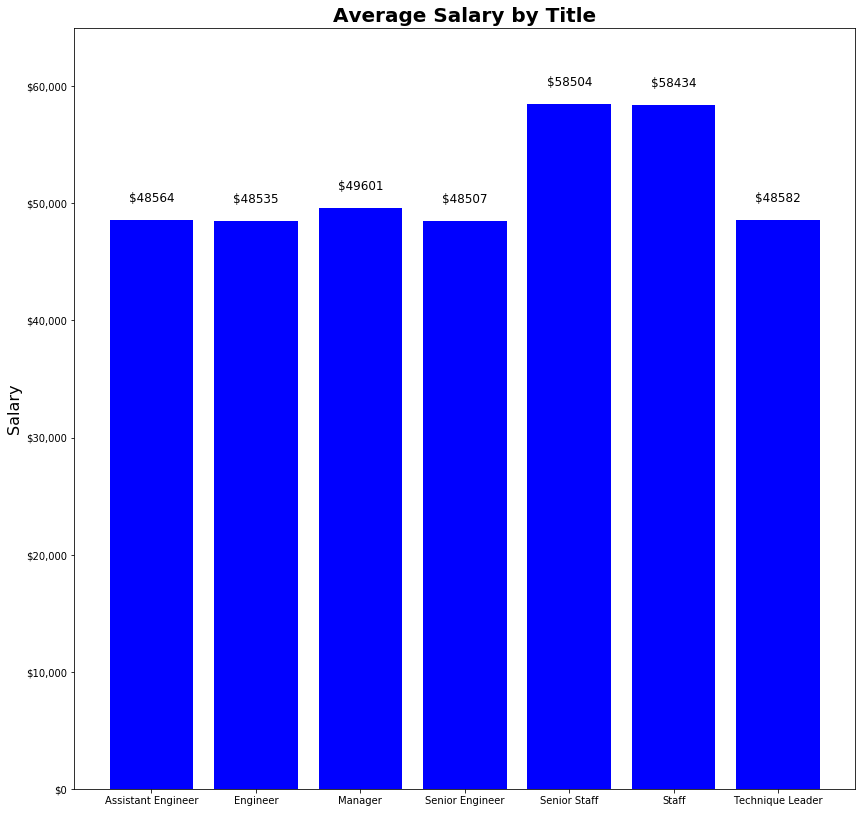

In [14]:
# Orient widths. Add labels, tick marks, etc.
fig, ax = plt.subplots(figsize=(14,14))

tick_locations = np.arange(len(avg_salary_df))
rects = ax.bar (tick_locations, height=avg_salary_df["salary"], align="center", color="blue")

ax.set_title ("Average Salary by Title", weight="bold", size=20)
ax.set_ylabel ("Salary", size=16)

# ax.set_xticklabels(tick_locations, drugs, rotation=0, ha="left")
ax.set_xticklabels(avg_salary_df.index, horizontalalignment="center")
ax.set_xticks(tick_locations)

# set the format of the yaxis numbers
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))
ax.set_ylim(0,65000)

# This chart looks better without a grid
# ax.grid ()

# Use functions to label the percentages of changes
def autolabel(rects, ax):
    # Get y-axis height to calculate label position from.
    (y_bottom, y_top) = ax.get_ylim()
    y_height = y_top - y_bottom

    for rect in rects:
        height = rect.get_height()

        # Fraction of axis height taken up by this rectangle
        p_height = (height / y_height)

#       Original code from the website http://composition.al/blog/2015/11/29/a-better-way-to-add-labels-to-bar-charts-with-matplotlib/
#          If we can fit the label above the column, do that;
#          otherwise, put it inside the column.
#        if p_height > 0.95: # arbitrary; 95% looked good to me.
#            label_position = height - (y_height * 0.05)
#        else:
#            label_position = height + (y_height * 0.01)

        # Position the label a bit above the bar on the y-axis
        label_position = height + (y_height * .02)
    
        # Write the text on the bars
        ax.text(rect.get_x() + rect.get_width()/2., label_position,
                '$%.0f' % height, ha='center', va='bottom', color='black', size=12)

# Call functions to implement the function calls
autolabel(rects, ax)

# Save the Figure
plt.savefig ('bonus_graph.png')

# Show the Figure
plt.show()

### Seems unusual that the "Senior Staff" and "Staff" would have very similar average salaries, and that their salaries would be significantly higher than "Manager", "Engineer", etc.

### Also, all the other categories have approximately the same salary.  Very unusual.  What's going on here???

### Who is employee # 499942 ???

In [15]:
employees_data_df.loc[employees_data_df['emp_no']==499942]

,emp_no,birth_date,first_name,last_name,gender,hire_date,salary,from_date_x,to_date_x,title,from_date_y,to_date_y
299966,499942,1963-01-10,April,Foolsday,F,1997-02-10,40000.0,1998-03-28,1999-03-28,Technique Leader,1998-03-28,9999-01-01


### Haha.  The name is "April Foolsday".